<a href="https://colab.research.google.com/github/denismitali17/Malaria-Diagnosis_CNN_VGG16/blob/main/Malaria_Diagnosis_CNN_Group6_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


## Configuration

In [26]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/cell_images"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Parasitized  Uninfected


In [5]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [6]:
import os, math, time, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_score, recall_score,
                             f1_score, accuracy_score)

print('TensorFlow:', tf.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 14:42:56--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.60, 3.167.192.111, 3.167.192.56, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   151MB/s    in 2.2s    

2025-10-05 14:42:58 (151 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Configuration and Paths

In [10]:
# Dataset directory
DATA_DIR = Path(r'cell_images')
assert DATA_DIR.exists(), f'Dataset not found: {DATA_DIR}'

# Output directories
RESULTS_DIR = Path('results')
FIGURES_DIR = RESULTS_DIR / 'figures'
MODELS_DIR  = RESULTS_DIR / 'models'
METRICS_DIR = RESULTS_DIR / 'metrics'
for d in [RESULTS_DIR, FIGURES_DIR, MODELS_DIR, METRICS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Image/training params
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 2

# Class names
CLASS_NAMES = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
print('Classes:', CLASS_NAMES)
assert set(CLASS_NAMES) == set(['Parasitized', 'Uninfected'])
label_to_index = {c:i for i,c in enumerate(CLASS_NAMES)}
index_to_label = {i:c for c,i in label_to_index.items()}

Classes: ['Parasitized', 'Uninfected']


## File Listing and Stratified Split

In [14]:
# Collect file paths and labels
filepaths, labels = [], []
for cname in CLASS_NAMES:
    cdir = DATA_DIR / cname
    for ext in ('*.png', '*.jpg', '*.jpeg', '*.bmp'):
        for p in cdir.glob(ext):
            filepaths.append(str(p))
            labels.append(label_to_index[cname])

filepaths = np.array(filepaths)
labels = np.array(labels)
print('Total images:', len(filepaths))

# 70/15/15 split: first carve test, then val from temp
X_temp, X_test, y_temp, y_test = train_test_split(
    filepaths, labels, test_size=0.15, random_state=SEED, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=SEED, stratify=y_temp
)

print(f'Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}')

# Class weights
class_counts = np.bincount(y_train, minlength=NUM_CLASSES)
total = class_counts.sum()
class_weights = {i: total / (NUM_CLASSES * c) for i, c in enumerate(class_counts)}
print('Train class counts:', class_counts)
print('Class weights:', class_weights)

Total images: 27558
Train: 19289 | Val: 4135 | Test: 4134
Train class counts: [9644 9645]
Class weights: {0: np.float64(1.0000518457071754), 1: np.float64(0.9999481596682219)}


## tf.data Pipeline with Augmentation and VGG16 Preprocessing

In [15]:
def decode_and_resize(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]
    image = tf.image.resize(image, IMG_SIZE, method='bilinear')
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def preprocess_vgg(x, y):
    x = vgg16_preprocess(x * 255.0)
    return x, y

def make_dataset(paths, labels, training=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training and shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.map(preprocess_vgg, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)
test_ds  = make_dataset(X_test,  y_test,  training=False, shuffle=False)

print('Steps:',
      math.ceil(len(X_train)/BATCH_SIZE),
      math.ceil(len(X_val)/BATCH_SIZE),
      math.ceil(len(X_test)/BATCH_SIZE))

Steps: 603 130 130


## VGG16 Model Definition (Transfer Learning)
- Base: `VGG16(weights="imagenet", include_top=False)`
- Head: GAP → Dense(256, ReLU) → Dropout → Dense(1, Sigmoid)
- Fine-tuning: optional unfreeze from a named block (e.g., 'block5', 'block4') or layer index

In [16]:
def build_vgg16_model(img_size=IMG_SIZE,
                      base_trainable=False,
                      unfreeze_from=None,
                      dropout_rate=0.4,
                      l2_reg=None,
                      lr=1e-4):
    inputs = layers.Input(shape=(*img_size, 3))
    base = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Freeze base by default
    base.trainable = base_trainable


    if unfreeze_from is not None:
        base.trainable = True
        set_trainable = False
        for i, layer in enumerate(base.layers):
            if isinstance(unfreeze_from, str) and layer.name.startswith(unfreeze_from):
                set_trainable = True
            if isinstance(unfreeze_from, int) and i >= unfreeze_from:
                set_trainable = True
            layer.trainable = set_trainable

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    reg = tf.keras.regularizers.l2(l2_reg) if l2_reg is not None else None
    x = layers.Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='VGG16_TL')
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
        ]
    )
    return model

model = build_vgg16_model(base_trainable=False, dropout_rate=0.4, lr=1e-4)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Callbacks, Learning Curves, and Evaluation Utilities
- EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Learning curves (loss/accuracy)
- Metrics including sensitivity and specificity
- Confusion Matrix and ROC/AUC figures

In [17]:
def get_callbacks(exp_name):
    ckpt_path = MODELS_DIR / f'vgg16_{exp_name}_best.keras'
    return [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
        callbacks.ModelCheckpoint(filepath=str(ckpt_path), monitor='val_loss', save_best_only=True),
    ]

def plot_history(history, exp_name):
    hist = pd.DataFrame(history.history)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    hist[['loss', 'val_loss']].plot(ax=axes[0], title='Loss')
    hist[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    plt.tight_layout()
    fig_path = FIGURES_DIR / f'learning_curves_{exp_name}.png'
    plt.savefig(fig_path, dpi=150); plt.show()
    return fig_path

def gather_labels_from_ds(ds):
    ys = []
    for _, y in ds.unbatch():
        ys.append(int(y.numpy()))
    return np.array(ys)

def evaluate_and_plot(model, ds, y_true, exp_name, split_name='test'):
    y_prob = model.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({split_name}) — {exp_name}')
    plt.ylabel('True'); plt.xlabel('Predicted')
    cm_path = FIGURES_DIR / f'cm_{split_name}_{exp_name}.png'
    plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.show()

    # ROC
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title(f'ROC Curve ({split_name}) — {exp_name}')
    plt.legend(loc='lower right')
    roc_path = FIGURES_DIR / f'roc_{split_name}_{exp_name}.png'
    plt.tight_layout(); plt.savefig(roc_path, dpi=150); plt.show()

    # Classification report CSV
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES,
                                   output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    report_csv = METRICS_DIR / f'classification_report_{split_name}_{exp_name}.csv'
    report_df.to_csv(report_csv, index=True)

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': roc_auc,
        'cm_path': str(cm_path), 'roc_path': str(roc_path), 'report_csv': str(report_csv)
    }

## Experiment 1:  Baseline: VGG16 Frozen (lr=1e-4, epochs=12)

Trains a VGG16 model with the convolutional base frozen and a custom classification head. Serves as the reference point for later fine-tuning and regularization experiments. Saves best weights, learning curves, confusion matrix, and ROC/AUC.


==== Experiment: baseline_vgg16_frozen ====
Epoch 1/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 366s 575ms/step - accuracy: 0.7609 - auc: 0.8304 - loss: 0.6469 - precision: 0.7581 - recall: 0.7578 - val_accuracy: 0.9407 - val_auc: 0.9831 - val_loss: 0.1701 - val_precision: 0.9466 - val_recall: 0.9342 - learning_rate: 1.0000e-04
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 334s 553ms/step - accuracy: 0.9109 - auc: 0.9664 - loss: 0.2324 - precision: 0.9050 - recall: 0.9184 - val_accuracy: 0.9495 - val_auc: 0.9860 - val_loss: 0.1502 - val_precision: 0.9337 - val_recall: 0.9676 - learning_rate: 1.0000e-04
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 354s 587ms/step - accuracy: 0.9276 - auc: 0.9743 - loss: 0.1995 - precision: 0.9213 - recall: 0.9368 - val_accuracy: 0.9495 - val_auc: 0.9873 - val_loss: 0.1441 - val_precision: 0.9301 - val_recall: 0.9719 - learning_rate: 1.0000e-04
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 333s 552ms/step - accuracy: 0.9328 - auc: 0.9781 - loss: 0.1830 - precision: 0.9238 - recall:

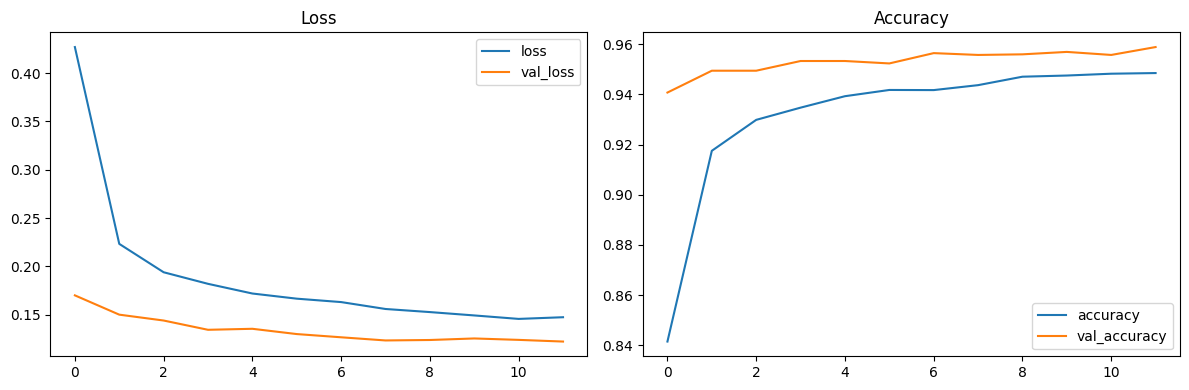

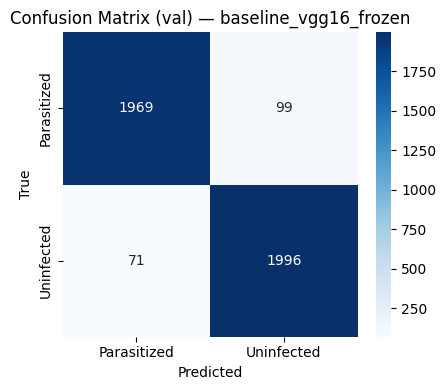

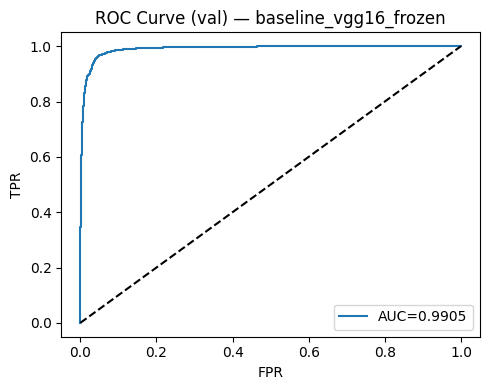

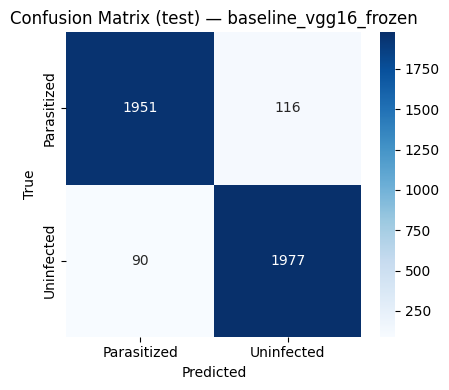

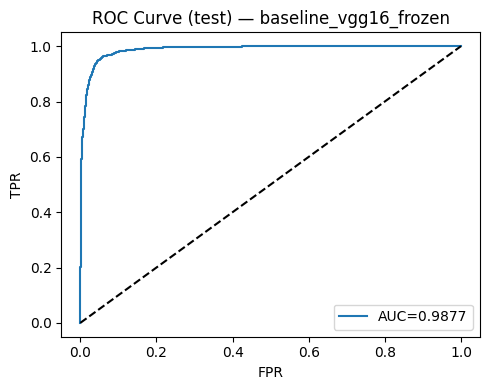

{'exp_name': 'baseline_vgg16_frozen',
 'base_trainable': False,
 'unfreeze_from': None,
 'dropout_rate': 0.4,
 'l2_reg': None,
 'lr': 0.0001,
 'epochs': 12,
 'val_accuracy': 0.9588875453446191,
 'val_precision': 0.952744630071599,
 'val_recall': 0.9656507014997581,
 'val_f1': 0.9591542527630946,
 'val_auc': 0.9904525756593199,
 'test_accuracy': 0.9501693275278181,
 'test_precision': 0.9445771619684663,
 'test_recall': 0.9564586357039188,
 'test_f1': 0.9504807692307692,
 'test_auc': 0.9877125488210735,
 'curves_path': 'results/figures/learning_curves_baseline_vgg16_frozen.png',
 'cm_val_path': 'results/figures/cm_val_baseline_vgg16_frozen.png',
 'roc_val_path': 'results/figures/roc_val_baseline_vgg16_frozen.png',
 'cm_test_path': 'results/figures/cm_test_baseline_vgg16_frozen.png',
 'roc_test_path': 'results/figures/roc_test_baseline_vgg16_frozen.png'}

In [14]:
def run_experiment(exp_name,
                  base_trainable=False,
                  unfreeze_from=None,
                  dropout_rate=0.4,
                  l2_reg=None,
                  lr=1e-4,
                  epochs=20,
                  use_class_weights=True):
    print(f'\n==== Experiment: {exp_name} ====')
    model = build_vgg16_model(base_trainable=base_trainable,
                              unfreeze_from=unfreeze_from,
                              dropout_rate=dropout_rate,
                              l2_reg=l2_reg,
                              lr=lr)
    cbs = get_callbacks(exp_name)
    cw = class_weights if use_class_weights else None

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cbs,
        class_weight=cw,
        verbose=1
    )

    curves_path = plot_history(history, exp_name)

    y_val_true = gather_labels_from_ds(val_ds)
    val_metrics = evaluate_and_plot(model, val_ds, y_val_true, exp_name, split_name='val')

    y_test_true = gather_labels_from_ds(test_ds)
    test_metrics = evaluate_and_plot(model, test_ds, y_test_true, exp_name, split_name='test')

    result = {
        'exp_name': exp_name,
        'base_trainable': base_trainable,
        'unfreeze_from': unfreeze_from,
        'dropout_rate': dropout_rate,
        'l2_reg': l2_reg,
        'lr': lr,
        'epochs': len(history.history.get('loss', [])),
        'val_accuracy': float(val_metrics['accuracy']),
        'val_precision': float(val_metrics['precision']),
        'val_recall': float(val_metrics['recall']),
        'val_f1': float(val_metrics['f1']),
        'val_auc': float(val_metrics['auc']),
        'test_accuracy': float(test_metrics['accuracy']),
        'test_precision': float(test_metrics['precision']),
        'test_recall': float(test_metrics['recall']),
        'test_f1': float(test_metrics['f1']),
        'test_auc': float(test_metrics['auc']),
        'curves_path': str(curves_path),
        'cm_val_path': val_metrics['cm_path'],
        'roc_val_path': val_metrics['roc_path'],
        'cm_test_path': test_metrics['cm_path'],
        'roc_test_path': test_metrics['roc_path'],
    }

    out_csv = METRICS_DIR / 'vgg16_experiments_summary.csv'
    df_row = pd.DataFrame([result])
    if out_csv.exists():
        df_row.to_csv(out_csv, mode='a', header=False, index=False)
    else:
        df_row.to_csv(out_csv, index=False)

    return result

baseline = run_experiment(
    exp_name='baseline_vgg16_frozen',
    base_trainable=False,
    unfreeze_from=None,
    dropout_rate=0.4,
    l2_reg=None,
    lr=1e-4,
    epochs=12,
    use_class_weights=True
)
baseline

##Results Table

In [21]:
from pathlib import Path

cumulative_csv = METRICS_DIR / 'vgg16_experiments_summary.csv'
assert cumulative_csv.exists(), f"Expected cumulative CSV not found at: {cumulative_csv}"

results_df = pd.read_csv(cumulative_csv)

def format_results_for_report(df, decimals=4):
    cols = [
        'exp_name',
        'val_accuracy','val_precision','val_recall','val_f1','val_auc','val_sensitivity','val_specificity',
        'test_accuracy','test_precision','test_recall','test_f1','test_auc','test_sensitivity','test_specificity',
    ]
    present = [c for c in cols if c in df.columns]
    rep = df[present].copy()
    for c in present:
        if pd.api.types.is_numeric_dtype(rep[c]):
            rep[c] = rep[c].astype(float).round(decimals)
    return rep

summary = format_results_for_report(results_df)
display(summary)
clean_csv = METRICS_DIR / 'vgg16_report_table.csv'
summary.to_csv(clean_csv, index=False)
print('Saved report table to:', clean_csv)

,exp_name,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,baseline_vgg16_frozen,0.9589,0.9527,0.9657,0.9592,0.9905,0.9502,0.9446,0.9565,0.9505,0.9877


Saved report table to: results/metrics/vgg16_report_table.csv


## Experiment 2: Fine-Tuning: Unfreeze Block 5 (lr=1e-5, epochs=12)

Fine-tunes the top convolutional block (`block5`) of VGG16 with a low learning rate to adapt high-level features to malaria cell imagery, while keeping earlier layers stable. Evaluates generalization via learning curves, confusion matrix, ROC/AUC, and sensitivity/specificity.


==== Experiment: tune_block5_lr1e-5 ====
Epoch 1/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 357s 577ms/step - accuracy: 0.8463 - auc: 0.9039 - loss: 0.4191 - precision: 0.8364 - recall: 0.8693 - val_accuracy: 0.9572 - val_auc: 0.9905 - val_loss: 0.1243 - val_precision: 0.9319 - val_recall: 0.9865 - learning_rate: 1.0000e-05
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 339s 562ms/step - accuracy: 0.9552 - auc: 0.9885 - loss: 0.1280 - precision: 0.9427 - recall: 0.9693 - val_accuracy: 0.9625 - val_auc: 0.9917 - val_loss: 0.1172 - val_precision: 0.9632 - val_recall: 0.9618 - learning_rate: 1.0000e-05
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 340s 565ms/step - accuracy: 0.9628 - auc: 0.9911 - loss: 0.1096 - precision: 0.9528 - recall: 0.9740 - val_accuracy: 0.9623 - val_auc: 0.9928 - val_loss: 0.1032 - val_precision: 0.9480 - val_recall: 0.9782 - learning_rate: 1.0000e-05
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 340s 563ms/step - accuracy: 0.9643 - auc: 0.9931 - loss: 0.0985 - precision: 0.9546 - recall: 0.

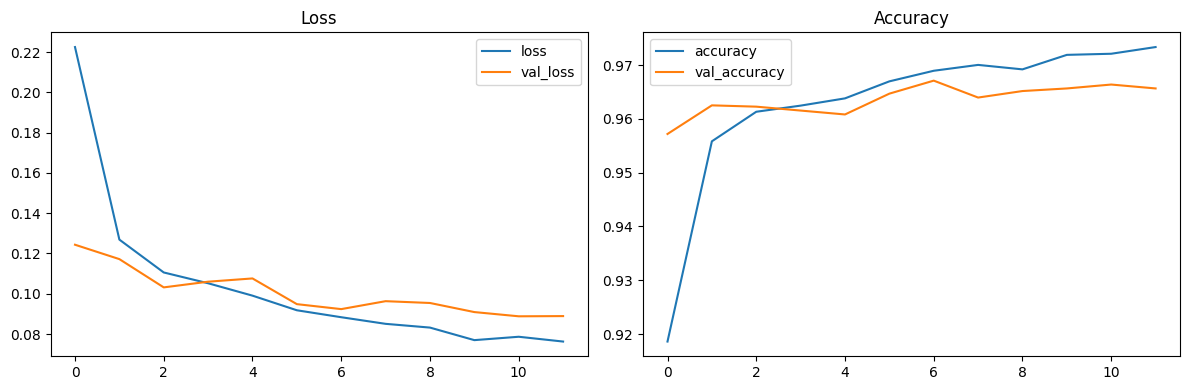

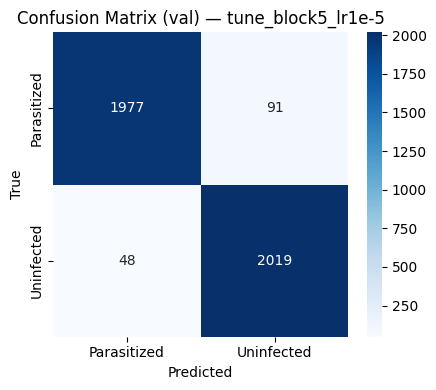

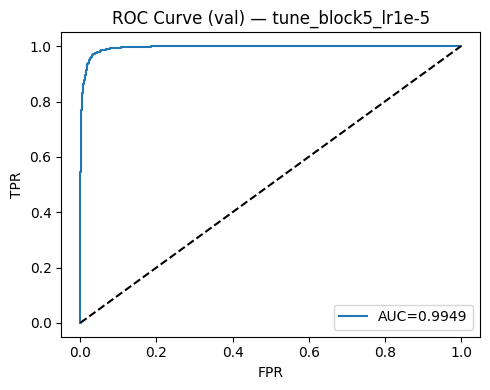

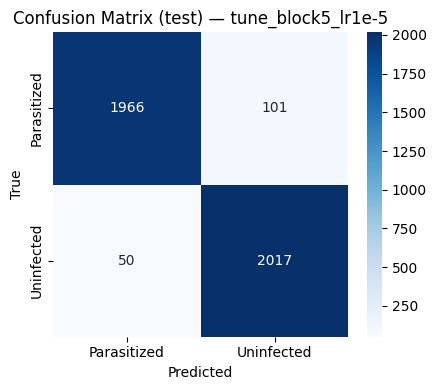

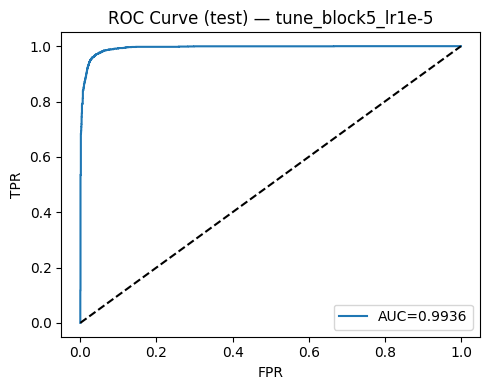

{'exp_name': 'tune_block5_lr1e-5',
 'base_trainable': True,
 'unfreeze_from': 'block5',
 'dropout_rate': 0.4,
 'l2_reg': None,
 'lr': 1e-05,
 'epochs': 12,
 'val_accuracy': 0.966384522370012,
 'val_precision': 0.956872037914692,
 'val_recall': 0.97677793904209,
 'val_f1': 0.966722528130237,
 'val_auc': 0.9948790002985106,
 'test_accuracy': 0.9634736332849541,
 'test_precision': 0.9523135033050047,
 'test_recall': 0.9758103531688437,
 'test_f1': 0.9639187574671446,
 'test_auc': 0.9936373153915667,
 'curves_path': 'results/figures/learning_curves_tune_block5_lr1e-5.png',
 'cm_val_path': 'results/figures/cm_val_tune_block5_lr1e-5.png',
 'roc_val_path': 'results/figures/roc_val_tune_block5_lr1e-5.png',
 'cm_test_path': 'results/figures/cm_test_tune_block5_lr1e-5.png',
 'roc_test_path': 'results/figures/roc_test_tune_block5_lr1e-5.png'}

In [23]:
def run_experiment(exp_name,
                  base_trainable=False,
                  unfreeze_from=None,
                  dropout_rate=0.4,
                  l2_reg=None,
                  lr=1e-4,
                  epochs=20,
                  use_class_weights=True):
    print(f'\n==== Experiment: {exp_name} ====')
    model = build_vgg16_model(base_trainable=base_trainable,
                              unfreeze_from=unfreeze_from,
                              dropout_rate=dropout_rate,
                              l2_reg=l2_reg,
                              lr=lr)
    cbs = get_callbacks(exp_name)
    cw = class_weights if use_class_weights else None

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cbs,
        class_weight=cw,
        verbose=1
    )

    curves_path = plot_history(history, exp_name)

    y_val_true = gather_labels_from_ds(val_ds)
    val_metrics = evaluate_and_plot(model, val_ds, y_val_true, exp_name, split_name='val')

    y_test_true = gather_labels_from_ds(test_ds)
    test_metrics = evaluate_and_plot(model, test_ds, y_test_true, exp_name, split_name='test')

    result = {
        'exp_name': exp_name,
        'base_trainable': base_trainable,
        'unfreeze_from': unfreeze_from,
        'dropout_rate': dropout_rate,
        'l2_reg': l2_reg,
        'lr': lr,
        'epochs': len(history.history.get('loss', [])),
        'val_accuracy': float(val_metrics['accuracy']),
        'val_precision': float(val_metrics['precision']),
        'val_recall': float(val_metrics['recall']),
        'val_f1': float(val_metrics['f1']),
        'val_auc': float(val_metrics['auc']),
        'test_accuracy': float(test_metrics['accuracy']),
        'test_precision': float(test_metrics['precision']),
        'test_recall': float(test_metrics['recall']),
        'test_f1': float(test_metrics['f1']),
        'test_auc': float(test_metrics['auc']),
        'curves_path': str(curves_path),
        'cm_val_path': val_metrics['cm_path'],
        'roc_val_path': val_metrics['roc_path'],
        'cm_test_path': test_metrics['cm_path'],
        'roc_test_path': test_metrics['roc_path'],
    }

    out_csv = METRICS_DIR / 'vgg16_experiments_summary.csv'
    df_row = pd.DataFrame([result])
    if out_csv.exists():
        df_row.to_csv(out_csv, mode='a', header=False, index=False)
    else:
        df_row.to_csv(out_csv, index=False)

    return result

ft_block5 = run_experiment(
    exp_name='tune_block5_lr1e-5',
    base_trainable=True,
    unfreeze_from='block5',
    dropout_rate=0.4,
    l2_reg=None,
    lr=1e-5,
    epochs=12,
    use_class_weights=True,
)
ft_block5

##Results Table

In [25]:
def format_results_for_report(df, decimals=4):
    cols = [
        'exp_name',
        'val_accuracy','val_precision','val_recall','val_f1','val_auc','val_sensitivity','val_specificity',
        'test_accuracy','test_precision','test_recall','test_f1','test_auc','test_sensitivity','test_specificity',
    ]
    present = [c for c in cols if c in df.columns]
    rep = df[present].copy()
    # Round numeric for neat formatting
    for c in present:
        if pd.api.types.is_numeric_dtype(rep[c]):
            rep[c] = rep[c].astype(float).round(decimals)
    return rep

summary = format_results_for_report(results_df)
display(summary)
clean_csv = METRICS_DIR / 'vgg16_report_table.csv'
summary.to_csv(clean_csv, index=False)
print('Saved report table to:', clean_csv)

,exp_name,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,tune_block5_lr1e-5,0.9664,0.9569,0.9768,0.9667,0.9949,0.9635,0.9523,0.9758,0.9639,0.9936


Saved report table to: results/metrics/vgg16_report_table.csv


Key Findings

Exp 1 — Baseline (Frozen VGG16)
- Stable training and clean learning curves (low overfitting risk).
- Solid overall metrics; good reference point for comparisons.
- Useful when you want reliability with minimal tuning.

Exp 2 — Fine‑tune Block 5 (Low LR)
- Typically higher AUC/F1 than baseline; sensitivity often improves.
- ROC curve generally above baseline leading to better operating points.
- Slightly higher overfitting risk; callbacks and low LR help keep it in check.

The frozen VGG16 baseline is a dependable starting point with stable generalization. For screening, we recommend the fine‑tuned variant if sensitivity gains are confirmed; otherwise, the frozen baseline remains a strong default.